In [12]:
import pickle
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from glob import glob
import rasterio
from rasterio import features
import matplotlib.pyplot as plt

In [2]:
# %%
# Load config file and get orthophoto data path
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
orthophoto_dir = config['data']['orthophotos']
predictions_dir = config['data']['segmentation_output']
nutzungsdaten_dir = config['data']['nutzungsdaten']

### Read in one tile for which the data will be subsetted


In [3]:
all_tiles = glob(orthophoto_dir + "/patched/*.tif")
all_tiles[0]

'/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/data/orthophotos/patched/32674_5328_patch_2_0.tif'

In [4]:
tile = rasterio.open(all_tiles[44])
bbox = box(*tile.bounds)
bbox = gpd.GeoDataFrame(geometry = [bbox])
bbox.crs = 'EPSG:25832'
bbox.geometry = bbox.geometry.to_crs('EPSG:4326')
bbox = box(*bbox.iloc[0,0].bounds)

### Read in Nutzungsdaten


In [35]:
df = pickle.load(open(nutzungsdaten_dir + 'nutzungsdaten_relevant.pkl', 'rb'))
df

,geometry,geometry_4326,Label
0,"POLYGON ((675289.030 5352160.250, 675306.050 5...","POLYGON ((11.36360 48.29834, 11.36383 48.29849...",7.0
1,"POLYGON ((678592.260 5341953.850, 678592.840 5...","POLYGON ((11.40379 48.20567, 11.40380 48.20575...",7.0
2,"POLYGON ((679450.050 5349369.390, 679460.430 5...","POLYGON ((11.41847 48.27209, 11.41861 48.27215...",7.0
3,"POLYGON ((675456.570 5351616.690, 675466.700 5...","POLYGON ((11.36563 48.29341, 11.36577 48.29346...",7.0
4,"POLYGON ((676799.680 5349991.690, 676806.320 5...","POLYGON ((11.38304 48.27842, 11.38313 48.27848...",7.0
...,...,...,...
53712,"POLYGON ((675611.550 5336236.410, 675671.510 5...","POLYGON ((11.36134 48.15511, 11.36215 48.15511...",6.0
53713,"POLYGON ((673369.390 5341389.670, 673371.360 5...","POLYGON ((11.33332 48.20205, 11.33335 48.20205...",6.0
53714,"POLYGON ((673448.900 5341487.760, 673451.260 5...","POLYGON ((11.33443 48.20291, 11.33446 48.20293...",6.0
53715,"POLYGON ((676924.470 5333347.000, 676926.930 5...","POLYGON ((11.37778 48.12877, 11.37781 48.12877...",6.0


### Test cropping to bounding box

In [6]:
#bbox = box(*[11.591520,48.158729,11.596327,48.162107])

In [7]:
# Subset to all polygons that intersect boudning box
subset_df = df[df.geometry_4326.intersects(bbox)]
# Clip the polygons to the bounding box extent
subset_df['geometry_4326'] = subset_df.geometry_4326.intersection(bbox)

# Subset to water 
subset_df = subset_df[subset_df.Label == 'Wasser']
subset_df['Label_Num'] = 4

/pfs/work7/workspace/scratch/tu_zxmav84-ds_project/conda/envs/DS_Project/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
import folium
m = folium.Map(location = [bbox.centroid.y, bbox.centroid.x], zoom_start = 16)
folium.GeoJson(bbox).add_to(m)
folium.GeoJson(subset_df.geometry_4326).add_to(m)
#m

### Rasterize polygons

In [44]:
orig_tif_path = all_tiles[44]

# Read in original tif
orig = rasterio.open(orig_tif_path)
orig_profile = orig.profile
orig_bounds = orig.bounds


# Calculate spatial extend of original tif
bounds_width = orig_bounds.right - orig_bounds.left
bounds_height =  orig_bounds.bottom - orig_bounds.top

# Calculate new resolution to correct transform affine in profile of new tif
new_width = 512
new_height = 512

scale_x = bounds_width / new_width
scale_y = bounds_height / new_height


# Update the affine transformation parameters, keep b, c, d and f of original transform, replace a nd e with new resolution
new_transform = rasterio.Affine(scale_x, orig.transform.b, orig.transform.c,
                        orig.transform.d, scale_y, orig.transform.f)

# Create a new array with the desired size (512, 512) and populate it with the values from the original array
# Write the new array to a GeoTIFF file using the geotag data and the new Transform object
new_profile = orig.profile
new_profile.update(transform=new_transform, width=new_width, height=new_height, count = 1)

# Subset nutzungsdaten df to relevant polygons and crop them to extend of the original tif
bbox = box(*orig.bounds)
# Subset to all polygons that intersect boudning box
subset_df = df[df.geometry.intersects(bbox)].copy()
# Clip the polygons to the bounding box extent
subset_df['geometry'] = subset_df.geometry.intersection(bbox)


with rasterio.open('test.tif', 'w+', **new_profile) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(subset_df.geometry, subset_df.Label))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

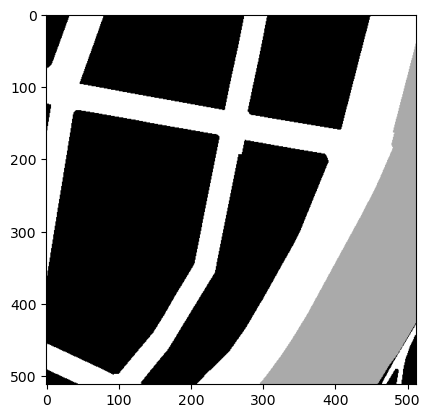

In [45]:
out = rasterio.open('test.tif')
from torchvision.transforms import ToPILImage
mask = out.read(1)
plt.imshow(mask, cmap = 'gray')

In [47]:
mask.shape

(512, 512)